<a href="https://colab.research.google.com/github/BrainConnection/Quantum_Algorithm/blob/main/1.%20TFIM%20VQE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [37]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install qiskit-algorithms

!pip install scipy
!pip install matplotlib

In [38]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Options

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum",
                                  token="067e5c82606f0a1157dd554e2087d6b7a9b823dbaa4ad47b95c3337eab2e6cd9361719cc0470f4a98d1631b73b264a82577012a0b8ff32963d5964e6cc12c525",
                                  set_as_default=True,
                                  overwrite=True)

service = QiskitRuntimeService()
backend = service.get_backend("ibmq_qasm_simulator")
backend.name

'ibmq_qasm_simulator'

# Exact Diagonalization

In [39]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector

import numpy as np

# Instantiate the system Hamiltonian
interation = 1
bias = -1
coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

In [40]:
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)
np.real(lowest_energy)

-6.155367074350501

In [41]:
eigenvalue

array([ 6.47213595e+00+3.95947359e-65j,  6.15536707e+00+2.24259449e-65j,
       -6.15536707e+00+1.92688231e-65j,  4.00000000e+00-1.10480914e-64j,
       -2.47213595e+00-7.72367187e-67j, -1.45308506e+00-7.34597347e-67j,
        1.45308506e+00+3.39861693e-66j, -5.23606798e+00+7.53805933e-65j,
        3.80422607e+00+2.59114310e-64j, -5.23606798e+00-3.75171788e-65j,
        3.80422607e+00+3.83073514e-67j, -3.80422607e+00+3.32197337e-65j,
       -3.80422607e+00+1.19426178e-63j, -3.23606798e+00-1.51929084e-64j,
       -3.23606798e+00+2.10831278e-64j, -2.35114101e+00-2.12700718e-63j,
       -2.35114101e+00-9.92761608e-63j,  2.35114101e+00+3.88938455e-62j,
        2.35114101e+00-1.70160574e-61j,  1.23606798e+00-6.22301528e-61j,
        1.23606798e+00+1.55818468e-60j, -7.63932023e-01-7.77876905e-62j,
       -7.63932023e-01-3.50016123e-61j,  2.00000000e+00+3.78015523e-49j,
        2.00000000e+00-3.78015523e-49j,  1.87539691e-16+2.36943565e-16j,
        1.87539691e-16-2.36943565e-16j,  2.00000000

# VQE Method 1

In [42]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector

import numpy as np

# Instantiate the system Hamiltonian
interation = 1
bias = -1
coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

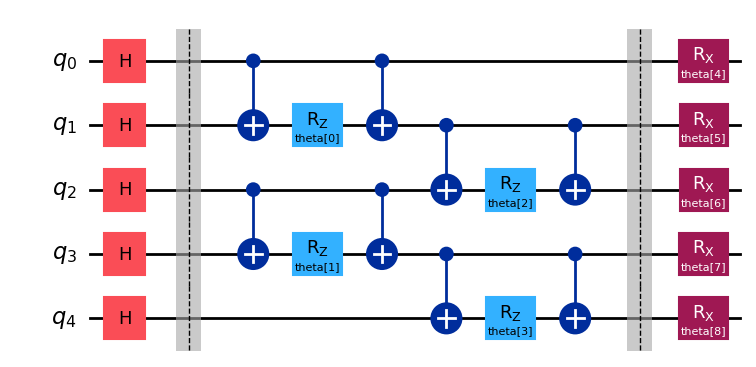

In [43]:
ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

In [44]:
from qiskit_algorithms.optimizers import CG
from qiskit_algorithms import VQE, SamplingVQE
from qiskit_algorithms.gradients import LinCombEstimatorGradient
from qiskit.primitives import Estimator

step_list = np.array([i for i in range(100)])
vqe_list = []

for max in range(100):

  # Conjugate Gradient algorithm
  optimizer = CG(maxiter=max)

  # Gradient callable
  estimator = Estimator()
  grad = LinCombEstimatorGradient(estimator)  # optional estimator gradient
  vqe = VQE(estimator=estimator, ansatz=ansatz, optimizer=optimizer, gradient=grad)

  result = vqe.compute_minimum_eigenvalue(hamiltonian)
  vqe_list.append(result.optimal_value)

vqe_list = np.array(vqe_list)

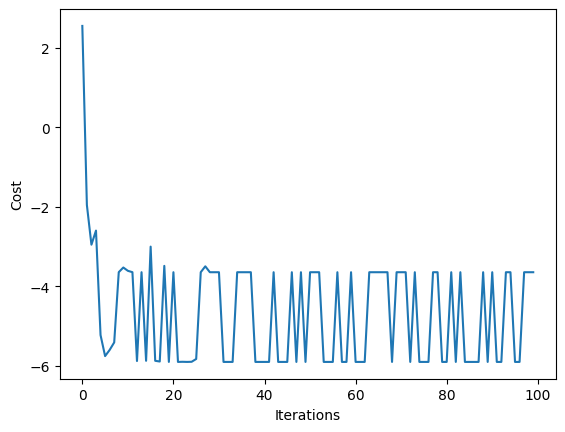

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(step_list, vqe_list)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

# VQE Method 2

In [46]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector

import numpy as np

# Instantiate the system Hamiltonian
interation = 1
bias = -1
coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

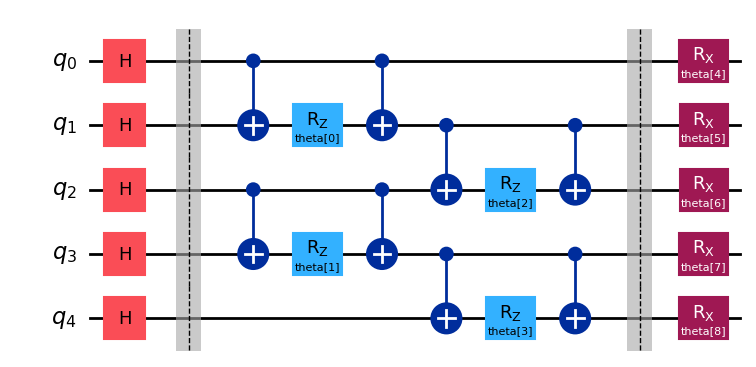

In [47]:
ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

In [48]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session


def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result()
    return cost

In [49]:
options = Options()
options.transpilation.skip_transpilation = True
options.execution.shots = 1000

estimator = Estimator(backend, options=options)

cost_func_vqe([1,1,1,1,1,1,1,1,1], ansatz, hamiltonian, estimator)

<ipython-input-48-abad034fee95>:16: DeprecationWarning: Circuits that do not match the target hardware definition will no longer be supported after March 1, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with operator transformations.
  cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result()


EstimatorResult(values=array([0.05828]), metadata=[{'variance': 8.120149165599999, 'shots': 100000}])

In [13]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [16]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

x0 = 2 * np.pi * np.random.random(10)

In [15]:
from scipy.optimize import minimize

options = Options()
options.transpilation.skip_transpilation = True
options.execution.shots = 10000

with Session(backend=backend):
    estimator = Estimator(options=options)
    callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
    res = minimize(
        cost_func_vqe,
        x0,
        args=(ansatz, hamiltonian, estimator),
        method="cobyla",
        callback=callback,
    )

<ipython-input-12-e694483318b5>:16: DeprecationWarning: Circuits that do not match the target hardware definition will no longer be supported after March 1, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with operator transformations.
  cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]


KeyboardInterrupt: 

In [ ]:
res

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()